## Question 1

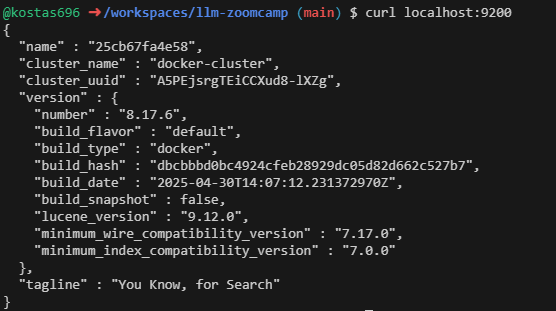

"build_hash" : "dbcbbbd0bc4924cfeb28929dc05d82d662c527b7"

## Question 2

In [1]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [5]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")
index_name = "faq-index"

# Define mapping
mapping = {
    "mappings": {
        "properties": {
            "question": {"type": "text"},
            "text": {"type": "text"},
            "course": {"type": "keyword"}
        }
    }
}

# Create index
es.indices.create(index=index_name, body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'faq-index'})

## Question 3

In [6]:
for i, doc in enumerate(documents):
    es.index(index=index_name, id=i, document=doc)

In [7]:
query = {
    "query": {
        "multi_match": {
            "query": "How do execute a command on a Kubernetes pod?",
            "fields": ["question^4", "text"],
            "type": "best_fields"
        }
    }
}

results = es.search(index=index_name, query=query["query"])

# Output top result
top = results["hits"]["hits"][0]
print("Top question:", top["_source"]["question"])
print("Score:", round(top["_score"], 2))

Top question: How do I debug a docker container?
Score: 44.51


## Question 4

In [ ]:
query = {
    "bool": {
        "must": {
            "multi_match": {
                "query": "How do copy a file to a Docker container?",
                "fields": ["question^4", "text"],
                "type": "best_fields"
            }
        },
        "filter": {
            "term": {
                "course": "machine-learning-zoomcamp"
            }
        }
    }
}

results = es.search(index=index_name, query=query, size=3)

# Print all 3 results
for i, hit in enumerate(results["hits"]["hits"], start=1):
    print(f"{i}. {hit['_source']['question']}")

1. How do I debug a docker container?
2. How do I copy files from my local machine to docker container?
3. How do I copy files from a different folder into docker container’s working directory?


## Question 5

In [10]:
# Build context
context = "\n\n".join([
    f"Q: {hit['_source']['question']}\nA: {hit['_source']['text']}"
    for hit in results["hits"]["hits"]
])

# Final prompt
question = "How do I execute a command in a running docker container?"

prompt = f"""
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

# Print and check length
print(prompt)
print("Length:", len(prompt))

You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: How do I execute a command in a running docker container?

CONTEXT:
Q: How do I debug a docker container?
A: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

Q: How do I copy files from my local machine to docker container?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:

## Question 6

In [11]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")
token_count = len(encoding.encode(prompt))
print("tiktoken count for GPT-4o:", token_count)

tiktoken count for GPT-4o: 322
